In [1]:
import numpy as np
import os
import shutil
import glob
from clease.settings import Concentration
from clease.settings import CEBulk
from clease.structgen import NewStructures
from ase.db import connect
from ase.io import read as ase_read
from ase.visualize import view
from ase.calculators.eam import EAM
from clease.tools import update_db
from clease import Evaluate
from clease import NewStructures
from clease.calculator import attach_calculator
from clease.montecarlo import Montecarlo
import clease

# from gpaw import GPAW
from ase.calculators.emt import EMT
import json

import clease.plot_post_process as pp
import matplotlib.pyplot as plt

If Lammps calc is needed, run cell below

In [7]:
from ase.calculators.lammpslib import LAMMPSlib

cmds = ["pair_style eim",
        "pair_coeff * * Na Li /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Na Li"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"
ASElammps = LAMMPSlib(lmpcmds=cmds, atom_types={'Na':1, 'Li':2}, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlog.log"))

In [2]:
from ase.calculators.lammpslib import LAMMPSlib

cmds = ["pair_style meam",
        "pair_coeff * * /Users/Michael_wang/Documents/venkat/MEAM/library.meam Li Mg /Users/Michael_wang/Documents/venkat/MEAM/LiMg.meam Li Mg"]
rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg"
ASElammps = LAMMPSlib(lmpcmds=cmds, atom_types={'Li':1, 'Mg':2}, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlogMg.log"))

util funcs code block ⬇️

In [3]:
import re, numpy
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter, ExpCellFilter, StrainFilter

def get_conc_from_formula(formula):
    sperated = re.split('Li|Mg', formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return int(sperated[1])/(int(sperated[2]) + int(sperated[1]))
    elif len(sperated) == 2:
        if formula[:2] == "Li":
            return 1
        elif formula[:2] == "Mg":
            return 0
    return numpy.inf

def energy_correction(self, formula, E):
    sperated = re.split('Li|Na', formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return E + int(sperated[1])*193.893 + int(sperated[2])*1296.886
    elif len(sperated) == 2:
        if formula[:2] == "Li":
            return E + int(sperated[1])*193.893
        elif formula[:2] == "Na":
            return E + int(sperated[1])*1296.886
    return np.inf

# def calculate_energies(db_name, myCalc, DEBUG = 0):
#     db = connect(db_name)

#     # finalScale = np.array(finalScale)
#     # finalX = np.array(finalX)
#     Xs = []
#     Ss = []

#     for row in db.select(converged=False):
#         fomula = row.formula
#         x = get_conc_from_formula(fomula)
#         # scale = (3.51*(x[-1]) + 4.29*(1-x[-1]))/3.9
#         atoms = row.toatoms()
#         scaleLower, scaleUpper = .96, 1.03
#         scales = np.linspace(scaleLower, scaleUpper, 60, endpoint=True)
#         E = []
#         for s in scales:
#             tmpAtoms = atoms.copy()
#             tmpAtoms.cell *= s
#             tmpAtoms.positions *= s
#             tmpAtoms.calc = myCalc
#             opt = BFGS(tmpAtoms, logfile="BFGS.log")
#             opt.run(fmax=0.02)
#             E.append(tmpAtoms.get_potential_energy())
#             if DEBUG == 1:
#                 print("at", x, "\tscale =", s, "\tenergy =", E[-1])
#             if len(E) >= 3 and E[-1] > E[-2] and E[-2] > E[-3]:
#                 break
        
#         finalScale = scales[np.argmin(np.array(E))]
#         if finalScale == scaleLower:
#             assert False, "Bring down lower scale"
#         if finalScale == scaleUpper:
#             assert False, "Bring up upper scale"
#         print("at x =", x, "scale =", finalScale)
#         Xs.append(x)
#         Ss.append(finalScale)
#         atoms.cell *= finalScale
#         atoms.positions *= finalScale
#         # atoms = attach_calculator(hhsettings, atoms=atoms, eci=eci)
#         atoms.calc = myCalc
#         opt = BFGS(atoms, logfile="BFGS.log")
#         opt.run(fmax=0.02)
#         E.append(atoms.get_potential_energy())
#         update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
#     return Xs, Ss

def calculate_energies(db_name, myCalc, DEBUG = 0):
    db = connect(db_name)

    # finalScale = np.array(finalScale)
    # finalX = np.array(finalX)
    Xs = []
    Ss = []

    for row in db.select(converged=False):
        fomula = row.formula
        x = get_conc_from_formula(fomula)
        atoms = row.toatoms()
        atomsInit = atoms.copy()
        oldV = atoms.cell.volume
        atoms.calc = myCalc

        ucf = UnitCellFilter(atoms)
        opt = BFGS(ucf)
        opt.run(fmax=0.02)
        atoms.get_potential_energy()
        
        finalScale = atoms.cell.volume/oldV
        print("at x =", x, "scale =", finalScale)
        Xs.append(x)
        Ss.append(finalScale)

        update_db(uid_initial=row.id, final_struct=atomsInit, db_name=db_name)
    return Xs, Ss

Setting up cluster expansion model

In [9]:
conc = Concentration(basis_elements=[['Li', 'Mg']])

db_name = "LiMg/bcc-NQP2-newInsert.db"

# hhsettings = CEBulk(crystalstructure='hcp',
#                   a=3.17,
#                   c=5.14,
#                   supercell_factor=64,
#                   concentration=conc,
#                   db_name=db_name,
#                   max_cluster_dia=[5.5,5.5,5.5],
#                   basis_func_type="polynomial")

# db_name = "LiMg/LiMg-Sep11-first-Batch-bcc-NQP.db"

hhsettings = CEBulk(crystalstructure='bcc',
                  a=4.33,
                  supercell_factor=64,
                  concentration=conc,
                  db_name=db_name,
                  max_cluster_dia=[5,5,5],
                  basis_func_type="polynomial")

In [10]:
genNum = 1

In [12]:
db_2 = connect("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/LiMg-Sep11-first-Batch-bcc-test-NQP.db")
for idx, row in enumerate(db_2.select('struct_type=initial')):
    if idx < 1 :
        print(genNum)
        atoms = row.toatoms()
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.insert_structure(atoms)
        genNum += 1

180


In [ ]:
from KianCalculator import KianCalc
calc = KianCalc("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/LiMg-Sep11-first-Batch-bcc-test-NQP-energy.db")

db = connect("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/bcc-NQP2-newInsert.db")

for idx, row in enumerate(db.select(converged=False)):
    print(idx)
    atoms = row.toatoms()
    atoms.calc = calc
    if calc.has_energy(atoms.symbols.formula._formula):
        atoms.get_potential_energy()
        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)

In [5]:
from KianCalculator import KianCalc
calc = KianCalc("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/LiMg-Sep11-first-Batch-hcp-NQP-energy.db")

db = connect("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/hcp-NQP2-newInsert.db")

for idx, row in enumerate(db.select(converged=False)):
    print(idx)
    atoms = row.toatoms()
    atoms.calc = calc
    if calc.has_energy(atoms.symbols.formula._formula):
        atoms.get_potential_energy()
        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)

done init!
0
Mg109LiMg60LiMg14LiMg30 -335.1720118802141
1
Mg26LiMg37LiMg24LiMg4LiMg67LiMg13LiMg39 -335.7047143928853
2
Mg86LiMg26LiMg22LiMg11LiMg2LiMg6LiMg18LiMg10LiMgLiMg25 -336.207117286991
3
Mg41LiMg15LiMg53LiMg10LiMg20LiMg7LiMg12LiMg6LiMg7LiMg2LiMg5Li2Mg26 -336.71383003640625
4
Mg6LiMg65LiMg17LiMgLiMg10LiMg4Li2Mg11LiMg15LiMg10LiMg3LiMg10LiMg24LiMg13LiMg6LiMg6 -337.22034787799834
5
LiMgLiMg18LiMg17LiMg12LiMg17LiMg5LiMg2Li2Mg37LiMg12LiMg8LiMg8LiMg5LiMg25LiMg11Li2Mg2LiMg18 -337.7699015282639
6
Mg2LiMg3LiMg4LiMg12LiMg12LiMg13LiMg2LiMg2LiMg14Li2MgLiMg6LiMg13LiMg10LiMgLiMg29Li2Mg32LiMg2LiMg19LiMg2LiMg16 -338.1411506230079
7
Mg5LiMg2LiMg4LiMg51LiMg4LiMg4LiMgLiMgLiMg2LiMg4LiMg9LiMgLiMg2Li2Mg11LiMgLiMg16LiMg14LiMg8Li2Mg7LiMg17LiMg2LiMg11LiMg15 -338.56272803483677
8
MgLiMg3Li3Mg4LiMg4Li2Mg5LiMg3LiMgLiMg10LiMg7LiMg21Li2MgLiMg13LiMg10Li2Mg23Li2Mg17LiMg18LiMg4LiMg4LiMg15Li2Mg3LiMg22 -339.1688009190726
9
MgLiMg4LiMg28LiMg13LiMgLiMg7Li2Mg19LiMg5LiMg7LiMg4LiMg10LiMg2LiMg8LiMgLiMg2LiMg2LiMgLi4Mg9Li

In [47]:
db_2 = connect("LiMg/LiMg-Sep11-first-Batch-hcp-NQP.db")
for idx, row in enumerate(db_2.select('struct_type=initial')):
    print(row)
print(idx)

<AtomsRow: formula=Mg216, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li3Mg213, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li6Mg210, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li9Mg207, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li12Mg204, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li15Mg201, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li18Mg198, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li21Mg195, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRow: formula=Li24Mg192, keys=gen,converged,started,queued,name,formula_unit,struct_type,final_struct_id>
<AtomsRo

In [43]:
idx

243

In [ ]:
BCC:    Li : 0.8158620689655173, Mg : 0.8254482758620689
HCP:    Li : 0.9832413793103448, Mg : 1.0120689655172415 

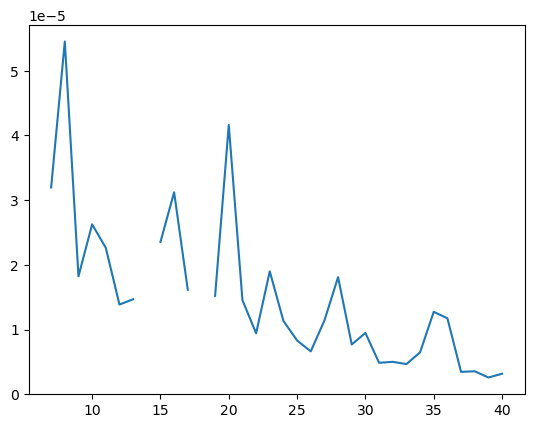

In [28]:
data = [-0.0001650446220000551, 0.00017812284519131254, -0.0001281795251236929, -7.6130892884745e-05, -6.268561198391328e-05, 0.000507725166710414, 0.00019389316908382186, 3.1947810190348605e-05, 5.451464217376626e-05, 1.82251089745601e-05, 2.625455830228342e-05, 2.262435151342727e-05, 1.3856392868824093e-05, 1.467100197186557e-05, 0.0012238224380562478, 2.352573553073294e-05, 3.120545662437107e-05, 1.6139110753737682e-05, -0.066151692566768, 1.5200966117687923e-05, 4.1605473970203504e-05, 1.4542757802095454e-05, 9.414329527011018e-06, 1.8984991772508777e-05, 1.1326868980174105e-05, 8.306171654107003e-06, 6.618388844742728e-06, 1.1391925368696268e-05, 1.8090504771852834e-05, 7.683786088648641e-06, 9.47469214689824e-06, 4.857948987222867e-06, 5.003131105196714e-06, 4.6553702969082245e-06, 6.468415738564169e-06, 1.2733691300083058e-05, 1.1733287895253211e-05, 3.4519591793429247e-06, 3.545817125422635e-06, 2.5857518406091692e-06, 3.159095858612705e-06]
for i in range(len(data)):
    if data[i] < 0 or data[i] > 0.000075:
        data[i] = np.nan

plt.plot(data)
plt.show()

In [23]:
template = hhsettings.prim_cell.copy()
for i in range(len(template.numbers)):
    template.numbers[i] = 12
template *= (4,4,4)
template.calc = ASElammps
scaleLower, scaleUpper = 0.9, 1.0
scales = np.linspace(scaleLower, scaleUpper, 30, endpoint=True)
E = []
for s in scales:
    tmpAtoms = template.copy()
    tmpAtoms.cell *= s
    tmpAtoms.positions *= s
    tmpAtoms.calc = ASElammps
    opt = BFGS(tmpAtoms, logfile="BFGS.log")
    opt.run(fmax=0.02)
    E.append(tmpAtoms.get_potential_energy())
    if 1:
        print("scale =", s, "\tenergy =", E[-1])

finalScale = scales[np.argmin(np.array(E))]
if finalScale == scaleLower:
    assert False, "Bring down lower scale"
if finalScale == scaleUpper:
    assert False, "Bring up upper scale"
print("scale =", finalScale)


scale = 1.01 	energy = -198.30450781070496
scale = 1.0106896551724138 	energy = -198.31100713259949
scale = 1.0113793103448276 	energy = -198.3146137759408
scale = 1.0120689655172415 	energy = -198.31534957991872
scale = 1.0127586206896553 	energy = -198.31323620661388
scale = 1.0134482758620689 	energy = -198.30829524774066
scale = 1.0141379310344827 	energy = -198.30054814182395
scale = 1.0148275862068965 	energy = -198.29001620132303
scale = 1.0155172413793103 	energy = -198.2767206547898
scale = 1.0162068965517241 	energy = -198.26068255509634
scale = 1.016896551724138 	energy = -198.24192288545925
scale = 1.0175862068965518 	energy = -198.22046248439977
scale = 1.0182758620689656 	energy = -198.19632206124646
scale = 1.0189655172413794 	energy = -198.16952224891412
scale = 1.0196551724137932 	energy = -198.14008350665392
scale = 1.0203448275862068 	energy = -198.10802622408838
scale = 1.0210344827586206 	energy = -198.07337065491015
scale = 1.0217241379310344 	energy = -198.036136

In [37]:
genNum

75

In [38]:
genNum = 1

In [34]:
db2insert = connect("LiNa/LiNa-Sep5-first-Batch-EOS-7-cutoff copy.db")
dbDest = connect(db_name)

for idx, row in enumerate(db2insert.select('')):
    if idx == 0:
        continue
    atoms = row.toatoms()
    ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
    ns.insert_structure(atoms)
    genNum += 1


In [10]:
template = hhsettings.prim_cell.copy()
template *= (2,2,2)
view(template)
template.calc = ASElammps
template.get_potential_energy()

-26.33612357762121

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [11]:
scaleLower, scaleUpper = 0.9, 1.0
scales = np.linspace(scaleLower, scaleUpper, 30, endpoint=True)
E = []
for s in scales:
    tmpAtoms = template.copy()
    tmpAtoms.cell *= s
    tmpAtoms.positions *= s
    tmpAtoms.calc = ASElammps
    opt = BFGS(tmpAtoms, logfile="BFGS.log")
    opt.run(fmax=0.02)
    E.append(tmpAtoms.get_potential_energy())
    if 1:
        print("scale =", s, "\tenergy =", E[-1])

finalScale = scales[np.argmin(np.array(E))]
if finalScale == scaleLower:
    assert False, "Bring down lower scale"
if finalScale == scaleUpper:
    assert False, "Bring up upper scale"
print("scale =", finalScale)

scale = 0.9 	energy = -25.26951736110345
scale = 0.903448275862069 	energy = -25.36764405795794
scale = 0.906896551724138 	energy = -25.462149147608947
scale = 0.9103448275862069 	energy = -25.55213899244317
scale = 0.9137931034482759 	energy = -25.634196163321317
scale = 0.9172413793103449 	energy = -25.71071322912508
scale = 0.9206896551724139 	energy = -25.78243353030607
scale = 0.9241379310344828 	energy = -25.849464787770195
scale = 0.9275862068965517 	energy = -25.911912698257208
scale = 0.9310344827586207 	energy = -25.96988096949761
scale = 0.9344827586206896 	energy = -26.02347135478782
scale = 0.9379310344827586 	energy = -26.072783686992285
scale = 0.9413793103448276 	energy = -26.11791591198585
scale = 0.9448275862068966 	energy = -26.158964121545807
scale = 0.9482758620689655 	energy = -26.196022585696564
scale = 0.9517241379310345 	energy = -26.22918378451781
scale = 0.9551724137931035 	energy = -26.258539172413748
scale = 0.9586206896551724 	energy = -26.284223489470516


In [8]:
ucf = UnitCellFilter(template)
opt = BFGS(ucf)
opt.run(fmax=0.02)
template.get_potential_energy()

      Step     Time          Energy         fmax
BFGS:    0 20:15:53      -26.336124        0.0915
BFGS:    1 20:15:53      -26.336434        0.0912
BFGS:    2 20:15:53      -26.368071        0.0320
BFGS:    3 20:15:53      -26.371622        0.0098


-26.37162170439301

In [9]:
for p in template.positions:
    print(p)

[ 2.46358541e-15  1.97335116e-16 -2.40793953e-15]
[1.74825208e-15 1.79604175e+00 2.53298470e+00]
[2.44941482e-15 9.23636487e-16 5.06596939e+00]
[1.54121192e-15 1.79604175e+00 7.59895409e+00]
[-1.55541778e+00  2.69406263e+00 -1.55890443e-15]
[-1.55541778  4.49010438  2.5329847 ]
[-1.55541778  2.69406263  5.06596939]
[-1.55541778  4.49010438  7.59895409]
[ 3.11083557e+00 -2.37309739e-15 -2.67479526e-15]
[3.11083557 1.79604175 2.5329847 ]
[ 3.11083557e+00 -1.51144543e-15  5.06596939e+00]
[3.11083557 1.79604175 7.59895409]
[ 1.55541778e+00  2.69406263e+00 -1.57888245e-15]
[1.55541778 4.49010438 2.5329847 ]
[1.55541778 2.69406263 5.06596939]
[1.55541778 4.49010438 7.59895409]


In [116]:
template = hhsettings.prim_cell.copy()
for i in range(len(template.numbers)):
    template.numbers[i] = 12
template *= (6,6,3)
print(len(template.numbers))
view(template)
template.write("LiMg/LiMg-Mg-gs.db")

216


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [32]:
template = hhsettings.prim_cell.copy()
template *= (6,6,3)

numberOfConc = 73
for i in range(numberOfConc):
    ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
    ns.generate_random_structures(atoms=template, conc=np.array([i/(numberOfConc-1), 1-i/(numberOfConc-1)]))
    genNum += 1

In [34]:
Xs, Ss = calculate_energies(db_name, ASElammps, DEBUG=1)

      Step     Time          Energy         fmax
BFGS:    0 19:39:32     -333.907953        0.2005
BFGS:    1 19:39:33     -333.909643        0.2003
BFGS:    2 19:39:33     -334.022719        0.1840
BFGS:    3 19:39:33     -334.126200        0.1680
BFGS:    4 19:39:33     -334.220181        0.1521
BFGS:    5 19:39:33     -334.304754        0.1363
BFGS:    6 19:39:34     -334.380013        0.1208
BFGS:    7 19:39:34     -334.446048        0.1053
BFGS:    8 19:39:34     -334.502952        0.0901
BFGS:    9 19:39:34     -334.550816        0.0749
BFGS:   10 19:39:34     -334.589728        0.0600
BFGS:   11 19:39:35     -334.619780        0.0451
BFGS:   12 19:39:35     -334.641059        0.0305
BFGS:   13 19:39:35     -334.653654        0.0159
at x = 0 scale = 1.0334174600123314
      Step     Time          Energy         fmax
BFGS:    0 19:39:35     -334.479443        0.1888
BFGS:    1 19:39:35     -334.483271        0.1885
BFGS:    2 19:39:35     -334.549384        0.1784
BFGS:    3 19:39

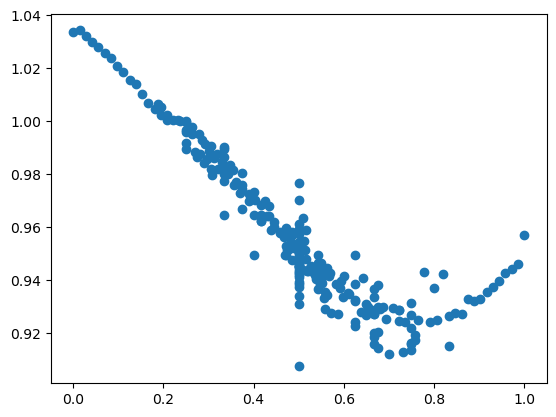

In [35]:
plt.plot(Xs, Ss, 'o')

In [61]:
np.polyfit(Xs, Ss, 6)

array([-1.63523948,  4.44352489, -4.44708269,  2.0816961 , -0.43532789,
       -0.01615746,  0.82522372])

In [78]:
np.polyfit(Xs, Ss, 3)

array([ 0.10226702, -0.09545872, -0.03450606,  1.01170911])

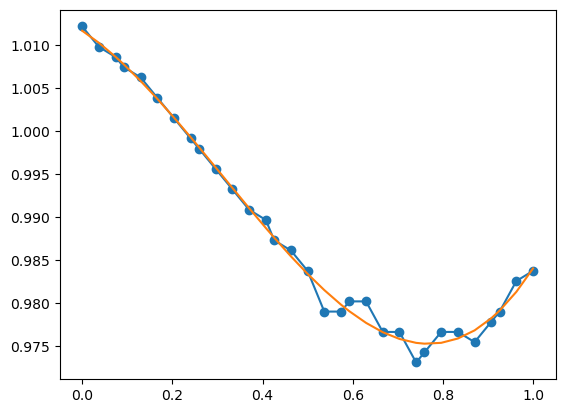

In [77]:
z = np.poly1d(np.polyfit(Xs, Ss, 3))
plt.plot(Xs, Ss, '-o')
plt.plot(Xs, z(Xs))

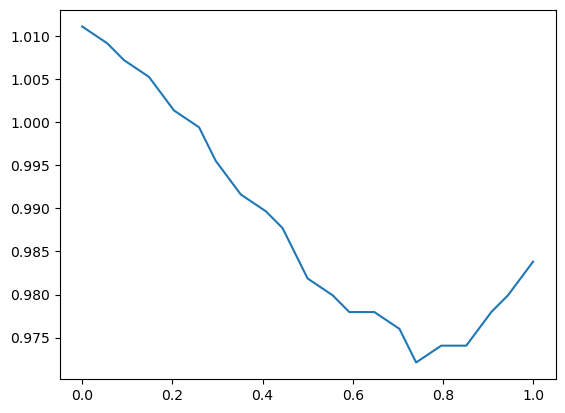

In [21]:
tmp = np.array([Xs, Ss])
plt.plot(tmp[0], tmp[1])

In [22]:
np.save("Mg_scaling.npy", tmp)

/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_95633/2933486510.py:6: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e2, num_alpha=150)


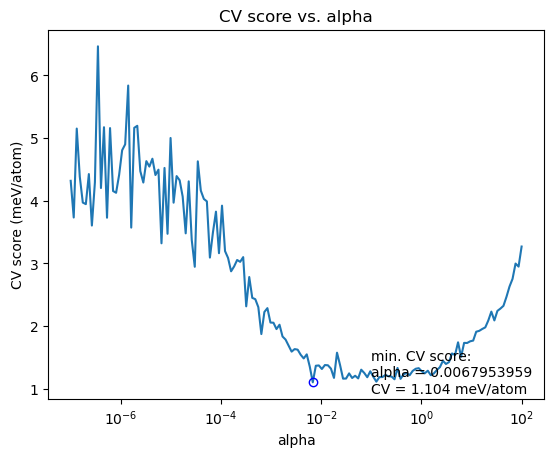

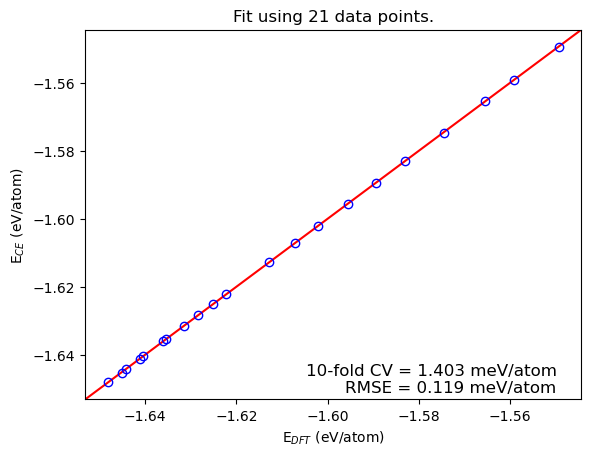

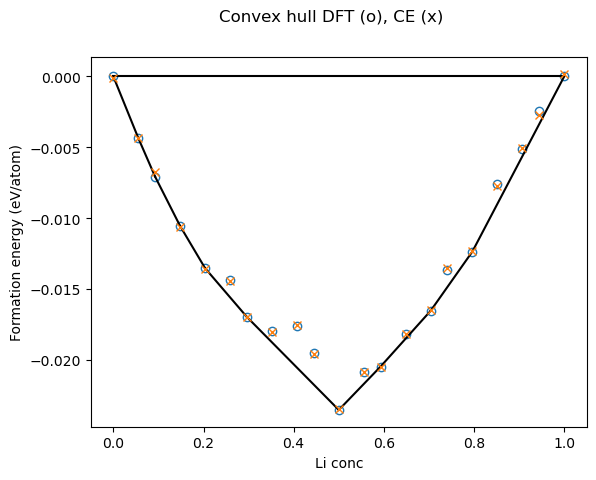

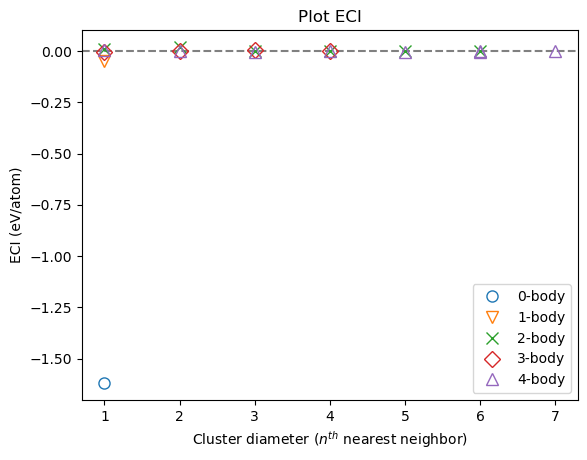

In [23]:
%matplotlib inline

eva = Evaluate(settings=hhsettings, scoring_scheme='k-fold', nsplits=10)
eva.set_fitting_scheme(fitting_scheme='l2')

alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e2, num_alpha=150)

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme='l2', alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

In [23]:
genNum

22

In [33]:
ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=177)
ns.generate_probe_structure()
genNum += 1

Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.
Supplied structure already exists in DB. The structure will not be inserted.


In [26]:
calculate_energies(db_name, ASElammps, 1)

      Step     Time          Energy         fmax
BFGS:    0 07:42:39     -219.424931        1.2444
BFGS:    1 07:42:39     -219.491300        1.2445
BFGS:    2 07:42:40     -220.238381        1.2458
BFGS:    3 07:42:40     -220.986195        1.2470
BFGS:    4 07:42:40     -221.734722        1.2481
BFGS:    5 07:42:40     -222.483939        1.2493
BFGS:    6 07:42:40     -223.233827        1.2504
BFGS:    7 07:42:40     -223.984363        1.2514
BFGS:    8 07:42:40     -224.735524        1.2524
BFGS:    9 07:42:40     -225.487291        1.2534
BFGS:   10 07:42:40     -226.239638        1.2544
BFGS:   11 07:42:40     -226.992545        1.2553
BFGS:   12 07:42:40     -227.745986        1.2562
BFGS:   13 07:42:40     -228.499941        1.2570
BFGS:   14 07:42:40     -229.254383        1.2578
BFGS:   15 07:42:41     -230.009290        1.2586
BFGS:   16 07:42:41     -230.764636        1.2593
BFGS:   17 07:42:41     -231.520398        1.2599
BFGS:   18 07:42:41     -232.276550        1.2606
B

([0,
  0.013888888888888888,
  0.027777777777777776,
  0.041666666666666664,
  0.05555555555555555,
  0.06944444444444445,
  0.08333333333333333,
  0.09722222222222222,
  0.1111111111111111,
  0.125,
  0.1388888888888889,
  0.1527777777777778,
  0.16666666666666666,
  0.18055555555555555,
  0.19444444444444445,
  0.20833333333333334,
  0.2222222222222222,
  0.2361111111111111,
  0.25,
  0.2638888888888889,
  0.2777777777777778,
  0.2916666666666667,
  0.3055555555555556,
  0.3194444444444444,
  0.3333333333333333,
  0.3472222222222222,
  0.3611111111111111,
  0.375,
  0.3888888888888889,
  0.4027777777777778,
  0.4166666666666667,
  0.4305555555555556,
  0.4444444444444444,
  0.4583333333333333,
  0.4722222222222222,
  0.4861111111111111,
  0.5,
  0.5138888888888888,
  0.5277777777777778,
  0.5416666666666666,
  0.5555555555555556,
  0.5694444444444444,
  0.5833333333333334,
  0.5972222222222222,
  0.6111111111111112,
  0.625,
  0.6388888888888888,
  0.6527777777777778,
  0.66666666666

/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_72112/3117348512.py:6: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e-5, num_alpha=1000)


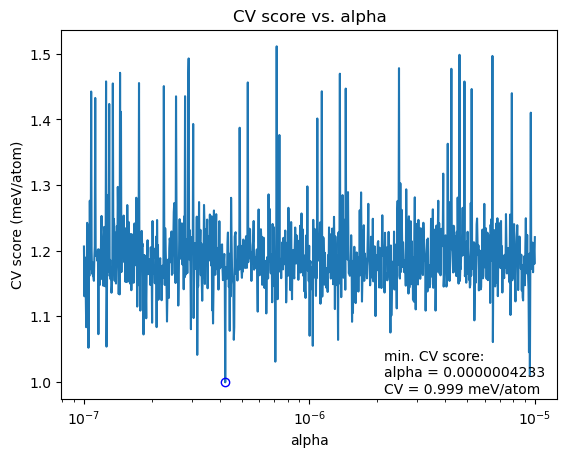

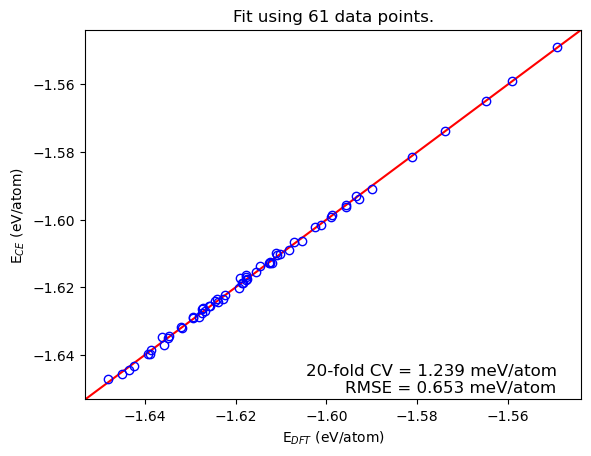

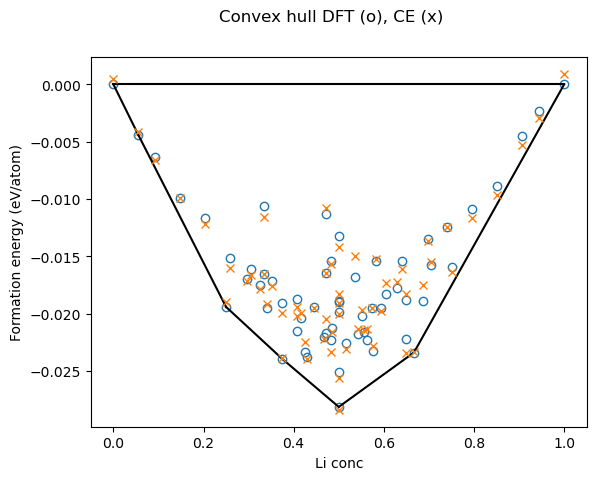

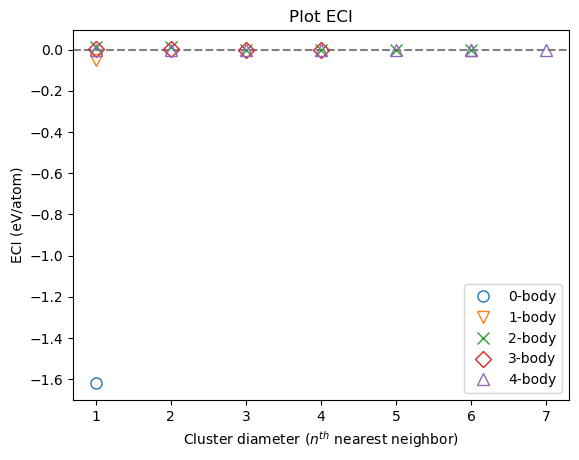

In [14]:
%matplotlib inline

eva = Evaluate(settings=hhsettings, scoring_scheme='k-fold', nsplits=20)
eva.set_fitting_scheme(fitting_scheme='l2')

alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e-5, num_alpha=1000)

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme='l2', alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

# eva.save_eci(fname=db_name + "-eci.json")

In [15]:
eva.save_eci(fname=db_name + "-eci.json")

In [5]:
genNum = 23

In [6]:
db = connect(db_name)
with open(db_name + "-eci.json") as f:
    eci = json.load(f)
iii = 0
skipped = 0
for row in db.select('struct_type=initial'):
    print("woring on:", iii)
    template = row.toatoms()
    try:
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.generate_gs_structure(atoms=template, init_temp=1e3,
                                    final_temp=1, num_temp=200,
                                    num_steps_per_temp=5000,
                                    eci=eci, random_composition=True)
        genNum += 1
    except:
        skipped += 1
        print(skipped, "structure skipped")
    iii += 1

woring on: 0
woring on: 1
woring on: 2
woring on: 3
woring on: 4
woring on: 5
woring on: 6
woring on: 7
woring on: 8


Could not generate ground-state structure in 10 attempts.


1 structure skipped
woring on: 9
woring on: 10
woring on: 11
woring on: 12


Could not generate ground-state structure in 10 attempts.


2 structure skipped
woring on: 13
woring on: 14
woring on: 15
woring on: 16
woring on: 17


Could not generate ground-state structure in 10 attempts.


3 structure skipped
woring on: 18


Could not generate ground-state structure in 10 attempts.


4 structure skipped
woring on: 19
woring on: 20
woring on: 21
5 structure skipped
woring on: 22
woring on: 23
woring on: 24
woring on: 25
woring on: 26
woring on: 27
woring on: 28
woring on: 29
woring on: 30
woring on: 31
woring on: 32
woring on: 33
woring on: 34
woring on: 35
woring on: 36
woring on: 37
woring on: 38
woring on: 39
6 structure skipped
woring on: 40
woring on: 41


Could not generate ground-state structure in 10 attempts.


7 structure skipped
woring on: 42
woring on: 43
woring on: 44
woring on: 45
woring on: 46
woring on: 47
woring on: 48
8 structure skipped
woring on: 49
9 structure skipped
woring on: 50
10 structure skipped
woring on: 51
woring on: 52
woring on: 53
woring on: 54
11 structure skipped
woring on: 55
12 structure skipped
woring on: 56
woring on: 57
woring on: 58
woring on: 59
woring on: 60


In [ ]:
calculate_energies(db_name)

In [18]:
%matplotlib inline

eva = Evaluate(settings=hhsettings, scoring_scheme='k-fold', nsplits=20)
eva.set_fitting_scheme(fitting_scheme='l2')

alpha = eva.plot_CV(alpha_min=1E-7, alpha_max=1e-5, num_alpha=150)

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme='l2', alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

# eva.save_eci(fname=db_name + "-eci.json")

KeyError: 'no match'

In [11]:
db2view = connect(db_name)
for idx, row in enumerate(db2view.select('')):
    view(row.toatoms())
    if idx > 21:
        break

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacE

In [19]:
db_del = connect("/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg/LiMg-Sep11-first-Batch-hcp-NQP2-ready.db")
db_del.delete(np.arange(246))

In [6]:
np.arange(23,43)

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42])

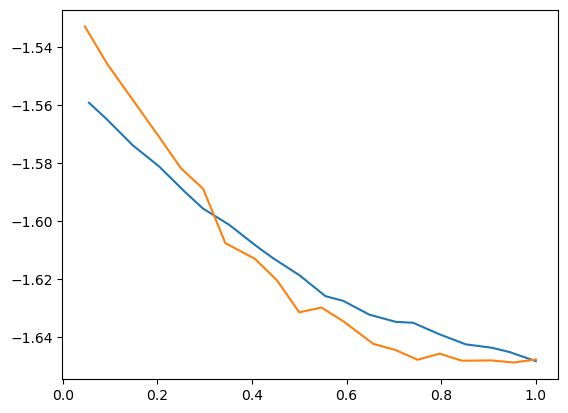

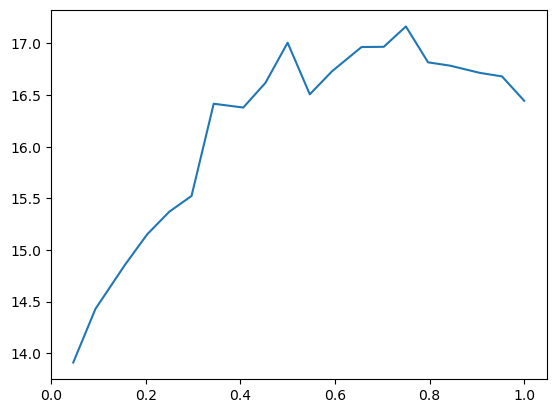

In [94]:
dbHcp = connect("LiMg/LiMg-Sep8-first-Batch-hcp.db")
dbBcc = connect("LiMg/LiMg-Sep8-first-Batch-bcc.db")

xHCP = []
EHCP = []
xBCC = []
EBCC = []
for idx, row in enumerate(dbHcp.select("struct_type=final")):
    if idx == 0 or idx > 20:
        continue
    xHCP.append(get_conc_from_formula(row.formula))
    atoms = row.toatoms()
    EHCP.append(atoms.get_potential_energy())

for idx, row in enumerate(dbBcc.select("struct_type=final")):
    if idx == 0 or idx > 20:
        continue
    xBCC.append(get_conc_from_formula(row.formula))
    atoms = row.toatoms()
    EBCC.append(atoms.get_potential_energy())

EHCP = np.array(EHCP)
EBCC = np.array(EBCC)

plt.plot(xHCP, EHCP/54)
plt.plot(xBCC, EBCC/64)
plt.figure()
plt.plot(xBCC, np.abs(EHCP - EBCC))


In [3]:
import numpy as np

In [5]:
data = np.load("/Users/Michael_wang/Downloads/aspirin_ccsd/aspirin_ccsd-train.npz", allow_pickle=True)
pass